In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from datetime import date
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D
from keras.utils.vis_utils import plot_model
from operator import add
import json
from matplotlib.backends.backend_pdf import PdfPages

data = pd.read_csv('SP500.csv')
# data['R_USD'] = data['Price'].pct_change()
# data = data.rename(columns={"Unnamed: 2": "Log_USD", "Unnamed: 3": "LR_SP"})
data.columns

data.tail()

,Date,Adj Close,Unnamed: 2,LR_SP
4520,15-03-2021,3968.939941,3.598675,-0.002810
4521,16-03-2021,3962.709961,3.597992,0.000682
4522,17-03-2021,3974.120117,3.599241,-0.001249
4523,18-03-2021,3915.459961,3.592783,0.006458
4524,19-03-2021,3913.100098,3.592521,0.000262


In [2]:
data = data.fillna(-0.005242)

In [3]:
data['LR_SP'].mean()

-0.0001479060591314917

In [3]:
data['Sqr_Ret'] = data['LR_SP']**2
#data = data[1:]
#data = data.reset_index()

In [4]:
data['exp_Vol'] = np.nan

In [5]:
(len(data['Sqr_Ret']))

4525

In [6]:
# data['exp_Vol'] = data['Sqr_Ret'].ewm(alpha=0.06,min_periods=66).mean()

In [7]:
lam = 0.06
n = 66
for i in range(66,(len(data['Sqr_Ret']))):
    inp = data['Sqr_Ret'].loc[i-66:i-1]
    x = inp.ewm(alpha=0.06,min_periods=66).mean()
    value = x.loc[i-1]
    data['exp_Vol'].loc[i] = value

C:\Users\kshit\Anaconda3\envs\my_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:
# for i in range(66,(len(data['Sqr_Ret']))):
#     inp = data['Sqr_Ret'].loc[i-66:i-1]
#     x = inp.mean()
#     value = x
#     data['exp_Vol'].loc[i] = value

In [9]:
# lam = 0.94
# n = 66
# wts = [(lam**(i-1) * (1-lam))/(1-lam**n) for i in range(0, n)]
# wts.reverse()
# wts = np.array(wts).reshape(1,-1)
# wts = wts/wts.sum()
# for i in range(66,(len(data['Sqr_Ret']))):
#     inp = data['Sqr_Ret'].loc[i-66:i-1]
#     inp = inp.to_numpy().reshape(-1,1)
#     tot = np.dot(wts,inp)
#     data['exp_Vol'].loc[i] = tot.sum()

In [10]:
# data['r']=data['LR_SP']*data['LR_SP']
# data['stdev_SP']=data['r']
# for i in range(2,len(data)):
#     data['stdev_SP'].loc[i]=0.9*data['stdev_SP'].loc[i-1]+0.1*data['r'].loc[i]
# data

In [11]:
# data['stdev_SP'] = data['stdev_SP'] **0.5

# data['Volatility_SP'] = data['stdev_SP'] 
# data['Volatility_SP'] = data['Volatility_SP']*100

# data['stdev_USD'] = data['Unnamed: 3'].rolling(window=66, center=False).std()
# data['stdev_USD'] = data['stdev_USD'].dropna()
# data['Volatility_SP'] = data['stdev_USD'] 
# # data['Volatility_SP'] = data['Volatility_SP']*100
data['exp_Vol'] = data['exp_Vol']**0.5
data['Volatility_SP'] = data['exp_Vol']*100
data.dropna(inplace=True)
symbols = ['Volatility_SP']
window_sizes = [22]
data

,Date,Adj Close,Unnamed: 2,LR_SP,Sqr_Ret,exp_Vol,Volatility_SP
66,03-07-2003,985.700012,2.993745,0.003532,1.247771e-05,0.004333,0.433292
67,07-07-2003,1004.419983,3.001915,-0.008171,6.675841e-05,0.004287,0.428731
68,08-07-2003,1007.840027,3.003392,-0.001476,2.179338e-06,0.004618,0.461780
69,09-07-2003,1002.210022,3.000959,0.002433,5.918813e-06,0.004478,0.447758
70,10-07-2003,988.700012,2.995065,0.005894,3.474162e-05,0.004382,0.438201
...,...,...,...,...,...,...,...
4520,15-03-2021,3968.939941,3.598675,-0.002810,7.897747e-06,0.004802,0.480176
4521,16-03-2021,3962.709961,3.597992,0.000682,4.654528e-07,0.004707,0.470688
4522,17-03-2021,3974.120117,3.599241,-0.001249,1.559259e-06,0.004566,0.456644
4523,18-03-2021,3915.459961,3.592783,0.006458,4.170837e-05,0.004437,0.443667


In [12]:
#data=data[250:] # just to ensure similar data size

In [13]:
data

,Date,Adj Close,Unnamed: 2,LR_SP,Sqr_Ret,exp_Vol,Volatility_SP
66,03-07-2003,985.700012,2.993745,0.003532,1.247771e-05,0.004333,0.433292
67,07-07-2003,1004.419983,3.001915,-0.008171,6.675841e-05,0.004287,0.428731
68,08-07-2003,1007.840027,3.003392,-0.001476,2.179338e-06,0.004618,0.461780
69,09-07-2003,1002.210022,3.000959,0.002433,5.918813e-06,0.004478,0.447758
70,10-07-2003,988.700012,2.995065,0.005894,3.474162e-05,0.004382,0.438201
...,...,...,...,...,...,...,...
4520,15-03-2021,3968.939941,3.598675,-0.002810,7.897747e-06,0.004802,0.480176
4521,16-03-2021,3962.709961,3.597992,0.000682,4.654528e-07,0.004707,0.470688
4522,17-03-2021,3974.120117,3.599241,-0.001249,1.559259e-06,0.004566,0.456644
4523,18-03-2021,3915.459961,3.592783,0.006458,4.170837e-05,0.004437,0.443667


In [14]:
# df5 = pd.read_csv("sp500_f_sgarch_252_f")
# df5

In [15]:
# data.iloc[3000:]

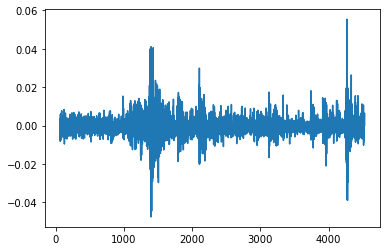

In [16]:
import matplotlib.pyplot as plt
plt.plot(data['LR_SP'])

In [17]:
def adj_r2_score(r2, n, k):
    return 1 - ((1 - r2) * ((n - 1) / (n - k - 1)))

def window_transform(time_series, window_size):
    X = []
    y = []
    for i in range(len(time_series) - window_size):
        X.append(time_series[i:i + window_size])
        y.append(time_series[i + window_size])

    return np.array(X), np.array(y)

def make_GARCH_lstm_model(window_size):
    model_lstm = Sequential()
    model_lstm.add(LSTM(256, input_shape=(window_size, 1), activation='relu', kernel_initializer='lecun_uniform', return_sequences=True))
    model_lstm.add(Dropout(0.05))
    model_lstm.add(LSTM(128, activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
    model_lstm.add(Dropout(0.05))
    model_lstm.add(Dense(1, activation='linear'))
    model_lstm.compile(loss='mean_squared_error', optimizer='adam')

    return model_lstm

def test_model(model, X_train, X_test, y_train, y_test):
    y_pred_test_ann = model.predict(X_test)
    y_train_pred_ann = model.predict(X_train)
    r2_train = mse(y_train, y_train_pred_ann)
    r2_test = mse(y_test, y_pred_test_ann)

    return r2_train, r2_test

def plot_all_model():
    print('plotting_model')
    ann_model = make_ann_model(3)
    cnn_model = make_cnn_model(3)
    lstm_model = make_lstm_model(3)
    gru_model = make_gru_model(3)

    plot_model(ann_model, to_file='ann_plot.png', show_shapes=True, show_layer_names=True)
    plot_model(cnn_model, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)
    plot_model(lstm_model, to_file='lstm_plot.png', show_shapes=True, show_layer_names=True)
    plot_model(gru_model, to_file='gru_plot.png', show_shapes=True, show_layer_names=True)


In [18]:
data['Date'] = pd.to_datetime(data['Date'])

In [19]:
data.head()

,Date,Adj Close,Unnamed: 2,LR_SP,Sqr_Ret,exp_Vol,Volatility_SP
66,2003-03-07,985.700012,2.993745,0.003532,0.000012,0.004333,0.433292
67,2003-07-07,1004.419983,3.001915,-0.008171,0.000067,0.004287,0.428731
68,2003-08-07,1007.840027,3.003392,-0.001476,0.000002,0.004618,0.461780
69,2003-09-07,1002.210022,3.000959,0.002433,0.000006,0.004478,0.447758
70,2003-10-07,988.700012,2.995065,0.005894,0.000035,0.004382,0.438201


Epoch 1/100
109/109 [==============================] - 7s 40ms/step - loss: 0.0056
Epoch 2/100
109/109 [==============================] - 4s 40ms/step - loss: 0.0090
Epoch 3/100
109/109 [==============================] - 4s 40ms/step - loss: 0.0062
Epoch 4/100
109/109 [==============================] - 5s 45ms/step - loss: 0.0016
Epoch 5/100
109/109 [==============================] - 5s 45ms/step - loss: 0.0034
Epoch 6/100
109/109 [==============================] - 4s 39ms/step - loss: 6.8278e-04
Epoch 7/100
109/109 [==============================] - 4s 37ms/step - loss: 0.0015
Epoch 8/100
109/109 [==============================] - 4s 37ms/step - loss: 4.7633e-04
Epoch 9/100
109/109 [==============================] - 4s 39ms/step - loss: 5.0905e-04
Epoch 10/100
109/109 [==============================] - 4s 38ms/step - loss: 3.6918e-04
Epoch 11/100
109/109 [==============================] - 4s 37ms/step - loss: 6.0093e-04
Epoch 12/100
109/109 [==============================] - 4s 37ms/s

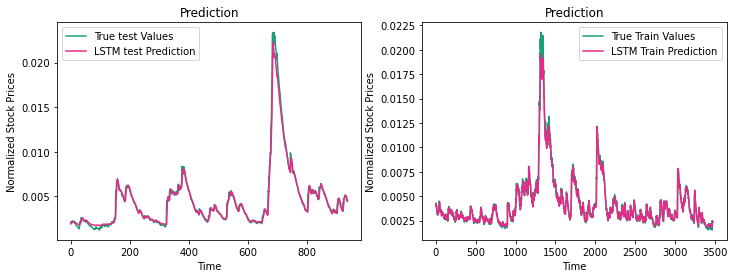

In [20]:
output=pd.DataFrame()
output_train=pd.DataFrame()
for sym in symbols: 
  df = data[sym]
  df.index = data['Date']
  df=pd.DataFrame(df)
  split_date = pd.Timestamp('01-01-2017')
  split_date = 3500 
  train = df.iloc[:split_date]
  test = df.iloc[split_date:]            
  sc = MinMaxScaler()
  train_sc = sc.fit_transform(train)
  test_sc = sc.transform(test)
  ann = []
  gru = []
  lstm = []
  cnn = []
  output[sym + "_" + "True_test"] = pd.Series(np.reshape(test_sc, ( -1)))
  output_train[sym + "_" + "True_train"] = pd.Series(np.reshape(train_sc, ( -1)))
  for win_sz in window_sizes:
    ann_result = []
    gru_result = []
    lstm_result = []
    cnn_result = []
    pred_ANN = []
    pred_LSTM = []
    pred_GRU = []
    pred_CNN = []
    pred_LSTM_train=[]
    X_train, y_train = window_transform(train_sc, win_sz)
    X_test, y_test = window_transform(test_sc, win_sz)
    X_tr_t = X_train.reshape(X_train.shape[0], win_sz, 1)
    X_tst_t = X_test.reshape(X_test.shape[0], win_sz, 1)
    for i in range(2):
      
      model = make_GARCH_lstm_model(win_sz)
      early_stop = EarlyStopping(monitor='loss', patience=6, verbose=1)
      history_model_GARCH_lstm = model.fit(X_tr_t, y_train, epochs=100, batch_size=32, verbose=1, shuffle=False,callbacks=[early_stop])

      train_acc, test_acc = test_model(model, X_tr_t, X_tst_t, y_train, y_test)
      y_pred_test_LSTM = model.predict(X_tst_t)
      y_pred_test_LSTM_train = model.predict(X_tr_t)
      lstm_result.append(test_acc)

      pred_LSTM.append(y_pred_test_LSTM)
      pred_LSTM_train.append(y_pred_test_LSTM_train)
      
    lstm.append([win_sz, min(lstm_result), np.mean(lstm_result), np.std(lstm_result)])
      
    plot_lstm = [0] * len(pred_LSTM[0])
    for pred in pred_LSTM:
        plot_lstm = list(map(add, plot_lstm, pred))

    for i in range(len(plot_lstm)):
        plot_lstm[i] = plot_lstm[i] / 2

    plot_lstm_train = [0] * len(pred_LSTM_train[0])
    for pred in pred_LSTM_train:
        plot_lstm_train = list(map(add, plot_lstm_train, pred))

    for i in range(len(plot_lstm_train)):
        plot_lstm_train[i] = plot_lstm_train[i] / 2
        
    plot_lstm = sc.inverse_transform(plot_lstm)
    plot_lstm_train = sc.inverse_transform(plot_lstm_train)
    plot_lstm = plot_lstm/100
    plot_lstm_train = plot_lstm_train/100
    y_test = sc.inverse_transform(y_test)
    y_test = y_test/100
    y_train = sc.inverse_transform(y_train)
    y_train = y_train/100
    
    output[sym + "_" + str(win_sz) + "_test_LSTM"] = pd.Series(np.reshape(plot_lstm, (-1)))
    output_train[sym + "_" + str(win_sz) + "_train_LSTM"] = pd.Series(np.reshape(plot_lstm_train, (-1)))
    output[sym + "_" + str(win_sz) + "_test_real_LSTM"] = pd.Series(np.reshape(y_test, (-1)))
    output_train[sym + "_" + str(win_sz) + "_train_real_LSTM"] = pd.Series(np.reshape(y_train, (-1)))
    f = plt.figure(figsize=(12,4))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    ax1.plot(y_test, '-', label='True test Values', color='#1b9e77')
    ax1.plot(plot_lstm, label='LSTM test Prediction', color='#e7298a')
    ax1.set_title("Prediction")
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Normalized Stock Prices')
    ax1.legend()

    ax2.plot(y_train, '-', label='True Train Values', color='#1b9e77')
    ax2.plot(plot_lstm_train, label='LSTM Train Prediction', color='#e7298a')
    ax2.set_title("Prediction")
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Normalized Stock Prices')
    ax2.legend()
#output.to_excel('output.xlsx')   
#output_train.to_excel('output_train.xlsx') 

In [21]:
df1 = output_train
df1.index = data['Date'].iloc[0:df1.shape[0]].values
df2 = output
df2.index = data['Date'].iloc[df1.shape[0]:(df1.shape[0]+df2.shape[0])].values
# df2=df2.shift(22) added this

In [22]:
#df1.to_csv('Çopper_train')
#df2.to_csv('Çopper_test')

In [23]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64
def create_download_link(df2, title = "Download CSV file", filename = "Copper_STD_test.csv"):
    csv = df2.to_csv(index=True)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)
create_download_link(df2)

In [24]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64
def create_download_link(df1, title = "Download CSV file", filename = "Copper_STD_train.csv"):
    csv = df1.to_csv(index=True)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)
create_download_link(df1)

In [25]:
df2.iloc[22:]

,Volatility_SP_True_test,Volatility_SP_22_test_LSTM,Volatility_SP_22_test_real_LSTM
2017-06-29,0.024859,0.001913,0.001603
2017-06-30,0.031916,0.001893,0.001576
2017-03-07,0.028812,0.001875,0.001529
2017-05-07,0.026336,0.001859,0.001500
2017-06-07,0.023483,0.001843,0.001469
...,...,...,...
2021-03-15,0.160749,NaN,NaN
2021-03-16,0.156064,NaN,NaN
2021-03-17,0.149128,NaN,NaN
2021-03-18,0.142719,NaN,NaN


In [26]:
data[data['Date']=='2012-01-08']

,Date,Adj Close,Unnamed: 2,LR_SP,Sqr_Ret,exp_Vol,Volatility_SP
2353,2012-01-08,1375.319946,3.138404,0.001261,0.000002,0.004339,0.433949


In [27]:
data.iloc[3022:]

,Date,Adj Close,Unnamed: 2,LR_SP,Sqr_Ret,exp_Vol,Volatility_SP
3088,2015-07-07,2081.340088,3.318343,-0.002633,6.932357e-06,0.003022,0.302154
3089,2015-08-07,2046.680054,3.311050,0.007293,5.318919e-05,0.003000,0.300033
3090,2015-09-07,2051.310059,3.312031,-0.000981,9.630537e-07,0.003421,0.342132
3091,2015-10-07,2076.620117,3.317357,-0.005326,2.836358e-05,0.003325,0.332468
3092,2015-07-13,2099.600098,3.322137,-0.004780,2.284388e-05,0.003481,0.348144
...,...,...,...,...,...,...,...
4520,2021-03-15,3968.939941,3.598675,-0.002810,7.897747e-06,0.004802,0.480176
4521,2021-03-16,3962.709961,3.597992,0.000682,4.654528e-07,0.004707,0.470688
4522,2021-03-17,3974.120117,3.599241,-0.001249,1.559259e-06,0.004566,0.456644
4523,2021-03-18,3915.459961,3.592783,0.006458,4.170837e-05,0.004437,0.443667


In [28]:
data

,Date,Adj Close,Unnamed: 2,LR_SP,Sqr_Ret,exp_Vol,Volatility_SP
66,2003-03-07,985.700012,2.993745,0.003532,1.247771e-05,0.004333,0.433292
67,2003-07-07,1004.419983,3.001915,-0.008171,6.675841e-05,0.004287,0.428731
68,2003-08-07,1007.840027,3.003392,-0.001476,2.179338e-06,0.004618,0.461780
69,2003-09-07,1002.210022,3.000959,0.002433,5.918813e-06,0.004478,0.447758
70,2003-10-07,988.700012,2.995065,0.005894,3.474162e-05,0.004382,0.438201
...,...,...,...,...,...,...,...
4520,2021-03-15,3968.939941,3.598675,-0.002810,7.897747e-06,0.004802,0.480176
4521,2021-03-16,3962.709961,3.597992,0.000682,4.654528e-07,0.004707,0.470688
4522,2021-03-17,3974.120117,3.599241,-0.001249,1.559259e-06,0.004566,0.456644
4523,2021-03-18,3915.459961,3.592783,0.006458,4.170837e-05,0.004437,0.443667
